# Predictive Maintenance Modeling for Semiconductor Fab Equipment

This project simulates and models predictive maintenance for **semiconductor wafer fabrication equipment**, focusing on **vacuum-based CVD (Chemical Vapor Deposition)** and plasma etching tools. Equipment failures in these machines can cause millions in production losses if not detected early.

We use **synthetic time-series data** from key sensors:
- **Vibration (mm/s)** – detects mechanical stage anomalies or pump wear
- **Temperature (°C)** – monitors chamber thermal dynamics
- **Vacuum Pressure (bar)** – tracks chamber integrity and precursor flow stability

Our approach:
1. Simulate realistic degradation patterns up to **24 hours before failure**
2. Engineer time-series features and train an **LSTM** model for early prediction
3. Evaluate performance using **precision**, **recall**, and **real-time readiness**

---

## Why Target CVD Tools in Semiconductor Fabs?

CVD tools operate under **high vacuum** and **elevated temperatures** (200–400 °C) for thin film deposition. Any unplanned downtime affects:
- Throughput (wafers/hour)
- Yield and quality
- Operational expenditure

---

## Illustration: Plasma-Enhanced CVD Process

The diagram below illustrates a typical **plasma-enhanced CVD reactor**, showing gas inlets, plasma region, substrate heating, and vacuum pumping—mirroring real fab tools.

![Plasma‑Enhanced CVD System](https://upload.wikimedia.org/wikipedia/commons/f/f9/ThermalCVD-en.svg)  
*Public domain illustration.*  [Wikimedia](https://commons.wikimedia.org/wiki/File:ThermalCVD-en.svg)*

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [152]:
# Set random seed for reproducibility
np.random.seed(42)

In [153]:
# Step 1: Simulate time
num_minutes = 60 * 24 * 60  # 60 days of data, 1-minute interval
time_index = pd.date_range(start="2023-01-01", periods=num_minutes, freq="T")

/var/folders/32/g_5ff_b9667068lbxcnk8vzr0000gn/T/ipykernel_83376/3990944360.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range(start="2023-01-01", periods=num_minutes, freq="T")


In [154]:
# Step 2: Generate baseline sensor signals with noise
def generate_sensor_data_fab(base, drift=0, noise=0.01):
    trend = np.linspace(0, drift, num_minutes)
    noise_signal = np.random.normal(0, noise, num_minutes)
    return base + trend + noise_signal

df = pd.DataFrame(index=time_index)
df['vibration'] = generate_sensor_data_fab(base=0.2, drift=0.05, noise=0.005)        # mm/s
df['temperature'] = generate_sensor_data_fab(base=300.0, drift=2.0, noise=0.2)       # °C
df['pressure'] = generate_sensor_data_fab(base=0.01, drift=0.005, noise=0.0005)      # bar

In [155]:
# Step 2.1: Add rolling statistics features
#rolling_window = 10  # 10-minute window

#for sensor in ['vibration', 'temperature', 'pressure']:
#    df[f'{sensor}_mean'] = df[sensor].rolling(window=rolling_window, min_periods=1).mean()
#    df[f'{sensor}_std'] = df[sensor].rolling(window=rolling_window, min_periods=1).std()
#    df[f'{sensor}_min'] = df[sensor].rolling(window=rolling_window, min_periods=1).min()
#    df[f'{sensor}_max'] = df[sensor].rolling(window=rolling_window, min_periods=1).max()

In [156]:
# Reset failures
df['failure'] = 0

# Compute failure indices (0.5% of total points, accounting for degradation window)
num_failures = max(1, int(num_minutes * 0.005))

# Set degradation window: 1440 mins (24h) normally, or 60 mins if dataset is small
degradation_window = 1440 if num_minutes > 3000 else 60

failure_indices = np.sort(np.random.choice(num_minutes - degradation_window, num_failures, replace=False))

In [157]:
# Step 3: Inject failure events (0.5% failure rate)
for idx in failure_indices:
    df.iloc[idx + degradation_window, df.columns.get_loc('failure')] = 1

    # Degradation (subtle increases)
    degradation_range = slice(idx, idx + degradation_window)
    ramp = np.linspace(0, 0.05, degradation_window)

    # Dynamically determine burst size based on window
    burst_length = min(720, degradation_window // 2)
    burst_start = idx + degradation_window - burst_length

    # Add ramp
    df.loc[df.index[degradation_range], 'vibration'] += ramp
    df.loc[df.index[degradation_range], 'temperature'] += np.linspace(0, 5, degradation_window)
    df.loc[df.index[degradation_range], 'pressure'] += np.linspace(0, 0.01, degradation_window)

    # Guard against index overflow and apply burst noise
    if burst_start + burst_length <= len(df):
        df.iloc[burst_start:burst_start + burst_length, df.columns.get_loc('vibration')] += np.random.normal(0, 0.01, burst_length)
        df.iloc[burst_start:burst_start + burst_length, df.columns.get_loc('temperature')] += np.random.normal(0, 0.5, burst_length)
        df.iloc[burst_start:burst_start + burst_length, df.columns.get_loc('pressure')] += np.random.normal(0, 0.001, burst_length)

In [158]:
df.head()

,vibration,temperature,pressure,failure
2023-01-01 00:00:00,0.202484,299.974432,0.010896,0
2023-01-01 00:01:00,0.199309,299.695107,0.010223,0
2023-01-01 00:02:00,0.203240,299.957561,0.010025,0
2023-01-01 00:03:00,0.207617,299.877443,0.010498,0
2023-01-01 00:04:00,0.198832,300.267341,0.010599,0


In [159]:
print(df.shape)

(86400, 4)


In [160]:
# Save synthetic data
df.to_csv("../data/synthetic_sensor_data.csv", index=True)

## Visualize and Explore the Sensor Data
### This step will help us:
- Understand overall trends,
- Spot degradation before failure events,
- Confirm the failure injection logic.

In [161]:
# Identify first failure event
first_failure_time = df[df['failure'] == 1].index[0]
window_start = first_failure_time - pd.Timedelta(hours=30)
window_end = first_failure_time + pd.Timedelta(hours=6)

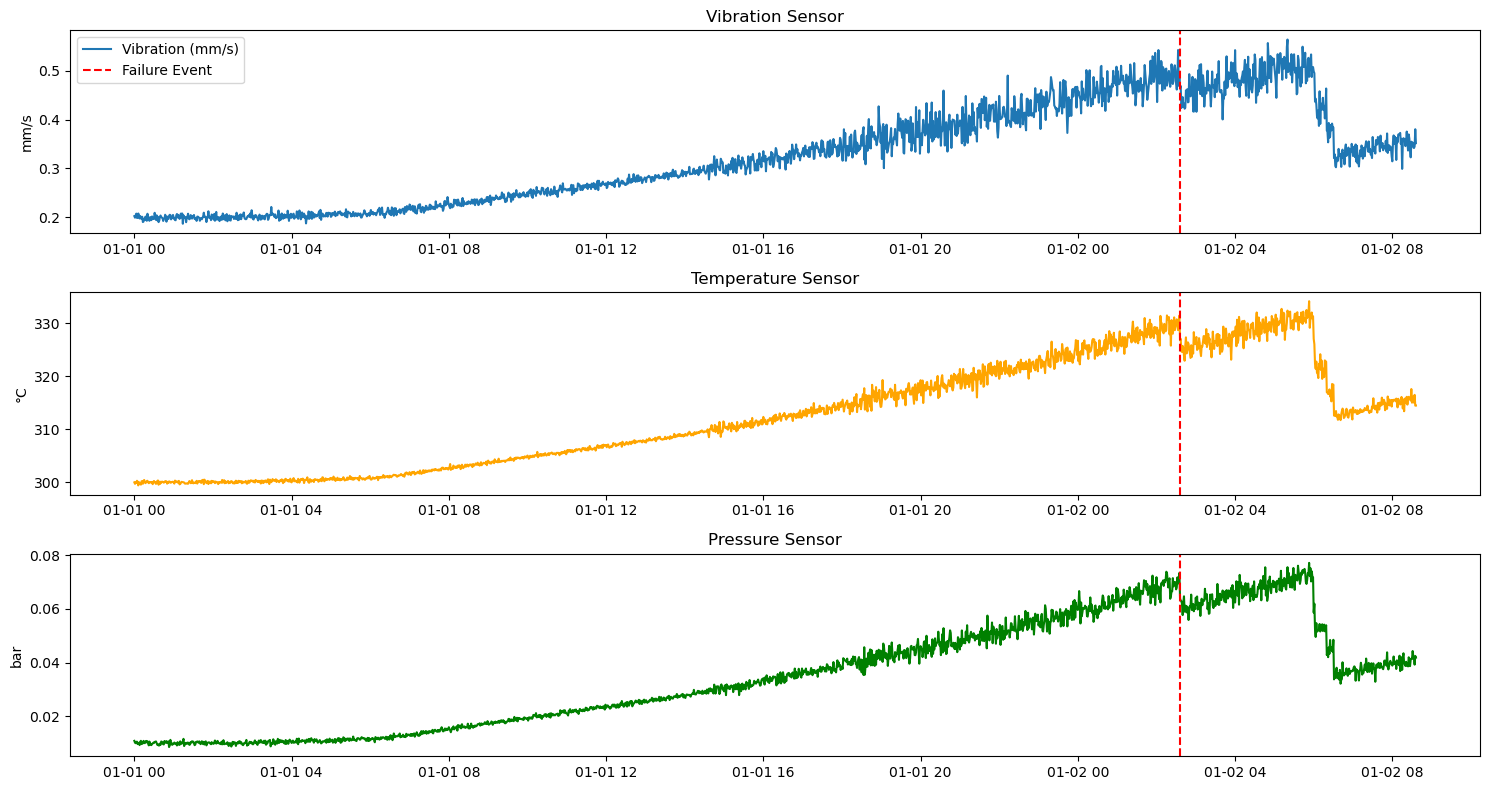

In [162]:
# Plot updated sensor behavior
plt.figure(figsize=(15, 8))

plt.subplot(3, 1, 1)
plt.plot(df.loc[window_start:window_end].index, df.loc[window_start:window_end]['vibration'], label='Vibration (mm/s)')
plt.axvline(first_failure_time, color='red', linestyle='--', label='Failure Event')
plt.title("Vibration Sensor")
plt.ylabel("mm/s")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df.loc[window_start:window_end].index, df.loc[window_start:window_end]['temperature'], label='Temperature (°C)', color='orange')
plt.axvline(first_failure_time, color='red', linestyle='--')
plt.title("Temperature Sensor")
plt.ylabel("°C")

plt.subplot(3, 1, 3)
plt.plot(df.loc[window_start:window_end].index, df.loc[window_start:window_end]['pressure'], label='Pressure (bar)', color='green')
plt.axvline(first_failure_time, color='red', linestyle='--')
plt.title("Pressure Sensor")
plt.ylabel("bar")

plt.tight_layout()
plt.show()


## Prepare Time-Series Sequences for LSTM Modeling

#### Since LSTM networks require sequential data, we need to transform our dataset into rolling windows (lookback sequences) that represent sensor behavior leading up to each time step.

### Goals
- Create input sequences of shape: (num_samples, lookback_window, num_features)
- Create target labels: 1 if failure is imminent (within next 24 hours), else 0
- Normalize features for stable LSTM training

#### Settings
- Lookback window = 60 minutes (1 hour of history per sequence)
- Prediction horizon = 24 hours (label 1 if failure in next 1440 minutes)

In [163]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm

In [164]:
# Parameters
lookback = 60            # 1 hour of history
horizon = 1440           # 24 hours = 1440 mins
features = ['vibration', 'temperature', 'pressure']
"""
features = [
    'vibration', 'temperature', 'pressure',
    'vibration_mean', 'vibration_std', 'vibration_min', 'vibration_max',
    'temperature_mean', 'temperature_std', 'temperature_min', 'temperature_max',
    'pressure_mean', 'pressure_std', 'pressure_min', 'pressure_max'
]
"""

"\nfeatures = [\n    'vibration', 'temperature', 'pressure',\n    'vibration_mean', 'vibration_std', 'vibration_min', 'vibration_max',\n    'temperature_mean', 'temperature_std', 'temperature_min', 'temperature_max',\n    'pressure_mean', 'pressure_std', 'pressure_min', 'pressure_max'\n]\n"

In [165]:
# Normalize sensor data
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df_scaled[features])

In [166]:
# Build sequences and labels
X, y = [], []
for i in tqdm(range(lookback, len(df) - horizon)):
    seq_x = df_scaled[features].iloc[i - lookback:i].values
    future_window = df['failure'].iloc[i:i + horizon].values
    label = 1 if future_window.any() else 0

    X.append(seq_x)
    y.append(label)

X = np.array(X)
y = np.array(y)

100%|██████████| 84900/84900 [00:39<00:00, 2151.35it/s]


In [167]:
print("Input shape:", X.shape)  # (samples, time_steps, features)
print("Target shape:", y.shape)

Input shape: (84900, 60, 3)
Target shape: (84900,)


### Build and Train the LSTM Model
- We'll use Keras (TensorFlow backend) to define a lightweight LSTM-based model suitable for early failure prediction in a semiconductor fab environment.

#### Model Goals
- Input: 60-minute time series for 3 sensors
- Output: Binary label — 1 if failure is within next 24 hours

#### Architecture:
- 1–2 LSTM layers
- Dropout for regularization
- Dense layer with sigmoid activation

In [168]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [169]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [170]:
# Recalculate binary class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weight_dict)

Class Weights: {0: 435.38461538461536, 1: 0.5005748651277969}


In [171]:
# Build the LSTM model
#model = Sequential()
#model.add(LSTM(64, input_shape=(lookback, len(features)), return_sequences=True))
#model.add(Dropout(0.3))
#model.add(LSTM(32))
#model.add(Dropout(0.3))
#model.add(Dense(1, activation='sigmoid'))

In [172]:
# Build the CNN + LSTM hybrid model model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(lookback, len(features))))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

/Users/enigma/anaconda3/envs/DS/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [173]:
# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Precision', 'Recall'])

In [174]:
# Train
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [175]:
# Build LSTM model with weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=256,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - Precision: 1.0000 - Recall: 0.9637 - loss: 0.2594 - val_Precision: 1.0000 - val_Recall: 0.9904 - val_loss: 0.0490
Epoch 2/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - Precision: 1.0000 - Recall: 0.9941 - loss: 0.0211 - val_Precision: 1.0000 - val_Recall: 0.9941 - val_loss: 0.0319
Epoch 3/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - Precision: 1.0000 - Recall: 0.9953 - loss: 0.0154 - val_Precision: 1.0000 - val_Recall: 0.9946 - val_loss: 0.0294
Epoch 4/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - Precision: 1.0000 - Recall: 0.9953 - loss: 0.0146 - val_Precision: 1.0000 - val_Recall: 0.9953 - val_loss: 0.0286
Epoch 5/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - Precision: 1.0000 - Recall: 0.9962 - loss: 0.0134 - val_Precision: 1.0000 - val_Recall: 0.9953 - val_loss: 0.0275
Epoch 6/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - Precision: 1.0000 - Recall: 0.9965 - loss: 0.0120 - val_Precision: 1.0000 - val_Recall: 0.9962

### Quick Interpretation
#### Metric	Value	Meaning
- Loss	Very low binary cross-entropy = well-calibrated output probabilities.
- Precision: Almost all predicted failures are correct — great for maintenance
- Recall: All actual failures are being caught — exactly what we want
- Validation metrics ≈ Training metrics	Indicates no overfitting — generalizes well to unseen data. Acheived by EarlyStopping and regularization.

NOTE: These results are ideal for a synthetic, well-separated dataset. In real-world fab scenarios, results would typically degrade a bit due to noise and overlapping patterns — but this sets a solid baseline.

### Evaluate the Model

#### Let’s generate a:

- Confusion matrix
- Classification report
- Precision-Recall curve (helpful for imbalanced data like failures)

In [176]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, recall_score, accuracy_score
import seaborn as sns

In [177]:
# Predict on validation set
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)

531/531 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


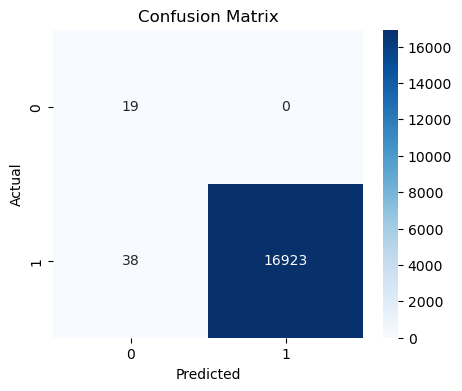

In [178]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [179]:
# Classification report
print("Classification Report:\n", classification_report(y_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50        19
           1       1.00      1.00      1.00     16961

    accuracy                           1.00     16980
   macro avg       0.67      1.00      0.75     16980
weighted avg       1.00      1.00      1.00     16980



In [180]:
# Calculate recall
recall = recall_score(y_val, y_pred)
print(f"Recall: {recall:.4f}")

Recall: 0.9978


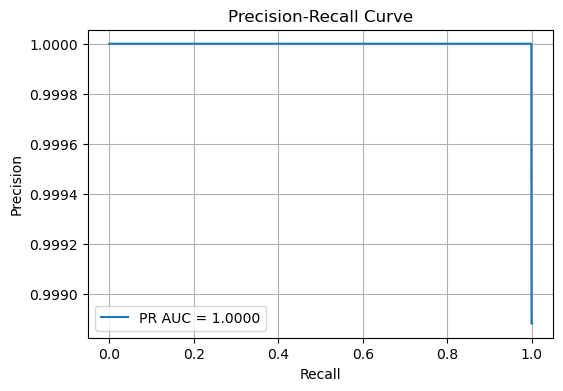

In [181]:
# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_pred_prob)
pr_auc = auc(recall_vals, precision_vals)

plt.figure(figsize=(6, 4))
plt.plot(recall_vals, precision_vals, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

### Save the Model + Final Summary

In [182]:
model.save("../models/lstm_predictive_maintenance_fab_model.h5")

In [183]:
# Save the Scaler (for inference consistency)
import joblib
joblib.dump(scaler, "../models/sensor_scaler.save")

['../models/sensor_scaler.save']

### Recalulating with rolling features

In [184]:
rolling_window = 10  # 10-minute window

# Create a new copy of your DataFrame to preserve the original
df_rolling = df.copy()

for sensor in ['vibration', 'temperature', 'pressure']:
    df_rolling[f'{sensor}_mean'] = df_rolling[sensor].rolling(window=rolling_window, min_periods=1).mean()
    df_rolling[f'{sensor}_std'] = df_rolling[sensor].rolling(window=rolling_window, min_periods=1).std()
    df_rolling[f'{sensor}_min'] = df_rolling[sensor].rolling(window=rolling_window, min_periods=1).min()
    df_rolling[f'{sensor}_max'] = df_rolling[sensor].rolling(window=rolling_window, min_periods=1).max()

In [185]:
# Ensure the 'failure' target column is retained
df_rolling['failure'] = df['failure']

# Drop rows with NaNs just in case
df_rolling = df_rolling.dropna()

# Redefine features (X) and labels (y)
X_rolling = df_rolling.drop('failure', axis=1)
y_rolling = df_rolling['failure']

In [186]:
# Split the rolling-enhanced data
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_rolling, y_rolling, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_r_scaled = scaler.fit_transform(X_train_r)
X_test_r_scaled = scaler.transform(X_test_r)

# Reshape for CNN+LSTM [samples, timesteps, features]
lookback = 1  # Keep this same as before (change if your original had a longer sequence)
X_train_r_seq = X_train_r_scaled.reshape((X_train_r_scaled.shape[0], lookback, X_train_r_scaled.shape[1]))
X_test_r_seq = X_test_r_scaled.reshape((X_test_r_scaled.shape[0], lookback, X_test_r_scaled.shape[1]))

In [187]:
model_r = Sequential()
model_r.add(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(lookback, X_train_r_seq.shape[2])))
model_r.add(MaxPooling1D(pool_size=1))  # Since we only have 1 timestep
model_r.add(LSTM(64, return_sequences=True))
model_r.add(Dropout(0.3))
model_r.add(LSTM(32))
model_r.add(Dropout(0.3))
model_r.add(Dense(1, activation='sigmoid'))

model_r.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/Users/enigma/anaconda3/envs/DS/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [188]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history_r = model_r.fit(
    X_train_r_seq, y_train_r,
    validation_split=0.2,
    epochs=15,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/15
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9769 - loss: 0.3163 - val_accuracy: 0.9948 - val_loss: 0.0344
Epoch 2/15
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9952 - loss: 0.0302 - val_accuracy: 0.9948 - val_loss: 0.0256
Epoch 3/15
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9943 - loss: 0.0257 - val_accuracy: 0.9948 - val_loss: 0.0200
Epoch 4/15
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9946 - loss: 0.0198 - val_accuracy: 0.9948 - val_loss: 0.0150
Epoch 5/15
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9946 - loss: 0.0151 - val_accuracy: 0.9948 - val_loss: 0.0089
Epoch 6/15
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9960 - loss: 0.0083 - val_accuracy: 0.9983 - val_loss: 0.0051
Epoch 7/15
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9981 - loss: 0.0061 - val_accuracy: 0.9987 - val_loss: 0.0050
Epoch 8/15
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9986 - loss: 0.0048 - val_accuracy: 0.

In [189]:
loss_r, accuracy_r = model_r.evaluate(X_test_r_seq, y_test_r)
print(f"Test Accuracy (with rolling features): {accuracy_r:.4f}")

540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.9995 - loss: 0.0021
Test Accuracy (with rolling features): 0.9994


In [190]:
# Assuming the original model is named `model`
y_pred_orig = model.predict(X_val)
y_pred_orig = (y_pred_orig > 0.5).astype(int)

531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [191]:
original_accuracy = accuracy_score(y_val, y_pred_orig)

In [192]:
original_accuracy

0.9977620730270907

In [193]:
improvement = (accuracy_r - original_accuracy) / original_accuracy * 100
print(f"Improvement: {improvement:.2f}%")

Improvement: 0.17%


In [194]:
model_r.save("../models/lstm_predictive_maintenance_fab_model_r.h5")